In [1]:
import numpy as np
import pandas as pd
from numpy.random import choice, normal, gamma, poisson
from scipy.stats import norm, invgamma
from scipy.stats import bernoulli
import scipy
import seaborn as sns
import math
from importlib import reload
from scipy.io import savemat

import matplotlib.pyplot as plt
import ParticleFilter
import Poisson_Tree_Particle_Filter

from scipy.stats import norm

from Tree_Node import *


In [2]:
seed = 17

# Data

In [3]:
def get_s_1(s_0, v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    
    return s_0 + v_0*dt + (1/2)*a_0*(dt**2)

def get_v_1(v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    
    return v_0 + a_0*dt

def generate_data(n_res, res, sigma_theta, s_x_0, v_x_0, s_y_0, v_y_0, gamma_shape=2, gamma_scale=1, seed=0):
    np.random.seed(seed)
    
    #generate tau
    tau = [0]
    
    while tau[-1] < n_res*res:
        tau.append(tau[-1] + np.random.gamma(shape=gamma_shape, scale=gamma_scale))

    _ = tau.pop()
    tau = np.array(tau)
    kT = len(tau)
    
    #generate acceleration at tau
    a_x_tau = np.random.normal(loc=0.0, scale=sigma_theta, size=kT)
    a_y_tau = np.random.normal(loc=0.0, scale=sigma_theta, size=kT)
           
    #compute states variables at tau
    s_x_tau, v_x_tau, = np.empty(kT), np.empty(kT)
    s_y_tau, v_y_tau, = np.empty(kT), np.empty(kT)
        
    s_x_tau[0], v_x_tau[0] = s_x_0, v_x_0
    s_y_tau[0], v_y_tau[0] = s_y_0, v_y_0
    
    for i1 in range(1, kT):
        i0 = i1 - 1
        s_x_tau[i1] = get_s_1(
            s_0=s_x_tau[i0],
            v_0=v_x_tau[i0],
            a_0=a_x_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
        s_y_tau[i1] = get_s_1(
            s_0=s_y_tau[i0],
            v_0=v_y_tau[i0],
            a_0=a_y_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
        v_x_tau[i1] = get_v_1(
            v_0=v_x_tau[i0],
            a_0=a_x_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
        v_y_tau[i1] = get_v_1(
            v_0=v_y_tau[i0],
            a_0=a_y_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
    
    
    #compute path/trajectory
    s_x, s_y = np.empty(n_res+1), np.empty(n_res+1)
    
    s_x[0], s_y[0] = s_x_0, s_y_0
    
    tau_index = 0
    for i in range(1, n_res+1):
        t = i*res
        
        #find last tau before this t
        while t > tau[tau_index]:
            tau_index += 1
        
            if tau_index == kT:
                break
            
        tau_index -= 1
        
        #compute coordinates at t
        s_x[i] = get_s_1(
            s_0=s_x_tau[tau_index],
            v_0=v_x_tau[tau_index],
            a_0=a_x_tau[tau_index],
            t_0=tau[tau_index],
            t_1=t,
        )
        s_y[i] = get_s_1(
            s_0=s_y_tau[tau_index],
            v_0=v_y_tau[tau_index],
            a_0=a_y_tau[tau_index],
            t_0=tau[tau_index],
            t_1=t,
        )
                
    return s_x_tau, s_y_tau, s_x, s_y, tau, a_x_tau, a_y_tau


def generate_observations(delta_t, res, mean, std, x, y):   
    step = int(delta_t / res)
    x_noisy, y_noisy = x[::step] + np.random.normal(mean, std, x[::step].size), y[::step] + np.random.normal(mean, std, y[::step].size)
    
    return x_noisy, y_noisy

T = 200
delta_t = 5
res = 1       #resolution for plotting hidden process

n_res = int(T / res)
n = int(T / delta_t)

sigma_theta = 10.0
sigma_obs = 200.0

gamma_shape = 10.0
gamma_scale = 2.5

lam = scipy.stats.gamma.cdf(delta_t, gamma_shape, scale=gamma_scale)
lam = T / (gamma_shape*gamma_scale*n)

s_x_0, s_y_0 = 64000, 29000
v_x_0, v_y_0 = 400, 0

s_x_tau, s_y_tau, s_x, s_y, tau_true, a_x_tau, a_y_tau = generate_data(
    n_res,
    res,
    sigma_theta,
    s_x_0=s_x_0,
    s_y_0=s_y_0,
    v_x_0=v_x_0,
    v_y_0=v_y_0,
    gamma_shape=gamma_shape,
    gamma_scale=gamma_scale,
    seed=seed
)

x_obs, y_obs = generate_observations(delta_t, res, mean=0.0, std=sigma_obs, x=s_x, y=s_y)

# Functions and settings

In [4]:
num_particles = 1000
lambda_0 = 50
delta_t_syn = delta_t * 2
sigma_obs = 800
gamma_shape = gamma_shape / 2
gamma_scale = gamma_scale / 2
b0 = 1
T_end = T
num_part = int(T_end / delta_t_syn)
num_obs_per_interval = int(delta_t_syn / delta_t)
print(num_obs_per_interval)
nodes_set = set()
V_act = []
V_end = []
prob_end = []
W_r0 = np.zeros(num_part + 1)
Gr_count = np.zeros(num_part + 1)
AS = False
        
keys = np.array(range(num_part + 1))
        
Fr = {k: [] for k in keys}
Fr_weights = {k: [] for k in keys}

2


In [5]:
def get_space(s_0, v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    return s_0 + v_0*dt + (1/2)*a_0*(dt**2)

In [6]:
def get_velocity(v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    return v_0 + a_0*dt

In [7]:
def get_likelihood(x_temp, x_obs, y_temp, y_obs, sigma_obs):
    pobsx_given_x, pobsy_given_y = norm.pdf(x_temp, x_obs, sigma_obs), norm.pdf(y_temp, y_obs, sigma_obs) 
    return pobsx_given_x*pobsy_given_y
  

In [8]:
def init_particles(s_x_0, s_y_0, v_x_0, v_y_0, sigma_theta, gamma_shape, gamma_scale, V_act, nodes_set, num_particles):
    for j in range(num_particles):
        sx, sy = s_x_0, s_y_0
        vx, vy = v_x_0, v_y_0
        ax, ay = np.random.normal(0, sigma_theta), np.random.normal(0, sigma_theta)  # this acceleration should not be needed 
        tau =  0
        particle = Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], None, 0, 0, 0, 0)
        V_act.append(particle)
        nodes_set.add(particle)
    return V_act, nodes_set

In [9]:
V_act, nodes_set = init_particles(s_x_0, s_y_0, v_x_0, v_y_0, sigma_theta, gamma_shape, gamma_scale, V_act, nodes_set, num_particles)

In [10]:
V_init = V_act.copy()

In [11]:
np.random.seed(seed)

# Algorithm

In [12]:
def sample_initial_params():
    return list_

In [13]:
def sample_initial_trajectory():
    return fixed_trajectory

In [14]:
def iterate(s_x_0, s_y_0, v_x_0, v_y_0, sigma_theta, gamma_shape, gamma_scale, V_act, nodes_set, num_particles, fixed_trajectory_nodes=None):
    V_act = []
    V_end = []
    prob_end = []
    W_r0 = np.zeros(num_part + 1)
    Gr_count = np.zeros(num_part + 1)
    b0 = 1
    T_end = T
    lambda_0 = 50
    delta_t_syn = delta_t * 4
    sigma_obs = 2000
    
    V_act, nodes_set = init_particles(s_x_0, s_y_0, v_x_0, v_y_0, sigma_theta, gamma_shape, gamma_scale, V_act, nodes_set, num_particles)
    
    if fixed_trajectory_nodes != None:
        #print(fixed_trajectory_nodes.type())
        list(V_act).extend(list(fixed_trajectory_nodes))
        
    while V_act:
        particle = V_act[0]
        
        if particle.get_parent() == None:
            Lambda = lambda_0
            particle.set_C(lambda_0)
            
        else:  # we now compute Lambda: in this case I call Lambda the intensity parameter multiplied my the weight
            
            if particle.get_in_F_r0() == 1:
                t_r = particle.get_t_r() 
    
                if (particle.get_W_ri() != 0.0) and (particle.get_W_ri() != 1.0):
                    #Lambda = (particle.get_W_ri() / W_r0[t_r]) * np.maximum(lambda_0 - Gr_count[t_r], b0) * 100
                    #print(particle.get_W_ri(), W_r0[t_r], Gr_count[t_r], t_r)
                    
                    #Lambda = (0.1) * np.maximum(lambda_0 - Gr_count[t_r], b0) 
                    #print(particle.get_W_ri() / W_r0[t_r], particle.get_W_ri(), W_r0[t_r])
                    Lambda = 1
                    
                else :
                    Lambda = 0
                #print(particle.get_W_ri(), W_r0[t_r], t_r, Lambda, particle.get_weight())
    
            else:
                
                Lambda = 1
            
            #if  (t_r > 0):
            #    if AS & (np.sum(Fr_weights[t_r - 1]) != 0):
            #        new_parent_index = choice(a = (np.array(range(len(Fr_weights[t_r - 1])))), size = 1, p = (Fr_weights[t_r - 1] / np.sum(Fr_weights[t_r - 1]) ))
        #
            #        new_parent = Fr[int(t_r - 1)][int(new_parent_index)]
            #        particle.set_parent(new_parent)
            # 
                
            parent = particle.get_parent()
            
            #particle.set_C(Lambda / particle.get_weight() * parent.get_C())
            #if particle.get_weight() != 0:
            #    particle.set_C((Lambda / particle.get_weight())* parent.get_C())
            #    print(particle.get_C())
            #else:
            #    particle.set_C(Lambda * parent.get_C())
        
        if (Lambda < 0) or (math.isnan(Lambda)):
            N = 0
        else:
            #print(Lambda)
            N = poisson(Lambda)
        
        if N > 0:
            for _ in range(N):
                tau = particle.get_tau() + np.random.gamma(shape=gamma_shape, scale=gamma_scale)
                
                t_r = int(tau // int(delta_t_syn))  #get last t_syn 
                if t_r > num_part:
                    t_r = num_part
                ax, ay = normal(0, sigma_theta), normal(0, sigma_theta)
                #parent = particle.get_parent()
                #if parent == None:
                #    parent_tau = 0
                #else:
                #    parent_tau = particle.get_parent().get_tau()
    
                sx = get_space(particle.get_sx(), particle.get_vx(), ax, particle.get_tau(), tau)
                sy = get_space(particle.get_sy(), particle.get_vy(), ay, particle.get_tau(), tau)
                vx = get_velocity(particle.get_vx(), ax, particle.get_tau(), tau)
                vy = get_velocity(particle.get_vy(), ay, particle.get_tau(), tau)
                
                t_obs_prec = int(tau // int(delta_t))  #get index of last obs
                if t_obs_prec > n:
                    t_obs_prec = n
                
                num_t_syn = t_r - particle.get_t_r()
                num_obs = t_obs_prec - particle.t_obs_prec
                likelihood = 1
                W_ri = 1
                
                # compute W_ri, W_r0 and G_r0 
                if num_t_syn > 0:
                    if num_t_syn > 2:
                  
                        for i in range(1, int(num_t_syn)):
                            Gr_count[int(t_r - i)] += 1
                            
                    t_obs = (t_r - 1) * num_obs_per_interval
                    
                    for obs in range(num_obs_per_interval):
                        x_temp = get_space(sx, vx, ax, particle.get_tau(), t_obs * delta_t)
                        y_temp = get_space(sy, vy, ay, particle.get_tau(), t_obs * delta_t)
                        W_ri_temp = get_likelihood(x_temp, x_obs[int(t_obs)], y_temp, y_obs[int(t_obs)],sigma_obs)
                        #if W_ri_temp != 0.0:
                        W_ri *= W_ri_temp
                        t_obs += 1
                    
                    if W_ri != 1.0:
                        W_r0[int(t_r)] += W_ri
                        #print(W_r0[int(t_r)], W_ri, t_r)
                        in_F_r0 = 1
                    else:
                        in_F_r0 = 0
                   
                else:
                    in_F_r0 = 0
                    
                for i in range(int(particle.t_obs_prec) + 1, int(t_obs_prec + 1)):
                    
                    x_temp = get_space(sx, vx, ax, i*delta_t, particle.get_tau())
                    y_temp = get_space(sy, vy, ay, i*delta_t, particle.get_tau())
                    
                    if i == int(particle.t_obs_prec) + 1:
                        likelihood_temp = get_likelihood(x_temp, x_obs[i], y_temp, y_obs[i], sigma_obs)
                        #if likelihood_temp != 0:
                        likelihood = likelihood_temp 
                    else:
                        likelihood_temp =  get_likelihood(x_temp, x_obs[i], y_temp, y_obs[i], sigma_obs)
                        #if likelihood_temp != 0:
                        likelihood = likelihood * likelihood_temp
                            
                if (likelihood != 0) & (likelihood != 1):
                    if in_F_r0 == 1:
                        child = Tree_Node (tau, [sx, sy], [vx, vy], [ax, ay], particle, likelihood, in_F_r0, t_r, t_obs_prec, W_ri)
                    elif in_F_r0 == 0:
                        child = Tree_Node (tau, [sx, sy], [vx, vy], [ax, ay], particle, likelihood, in_F_r0, t_r, t_obs_prec)
                
                    
                    Fr[t_r].append(child)
                    Fr_weights[t_r].append(child.get_weight())
                    particle.add_child_node(child)
                    
                    if tau > T_end:
                        V_end.append(child)
                        prob_end.append(child.get_weight())# / particle.get_C())
                    else:
                        V_act.append(child)
            
        V_act.remove(particle)
        
        
        
    return choice(V_end, 1, p = prob_end / np.sum(prob_end))
    
        

In [15]:
%%time

S = iterate(s_x_0, s_y_0, v_x_0, v_y_0, sigma_theta, gamma_shape, gamma_scale, V_act, nodes_set, num_particles)

Wall time: 1min 42s


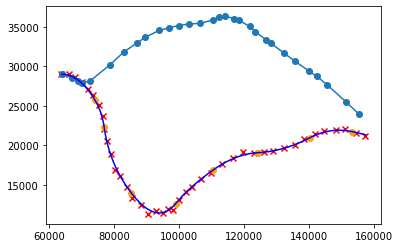

In [16]:
current_node = S[0]
trajectory_x_temp = []
trajectory_y_temp = []
fixed_trajectory = []

#fixed_trajectory.append(current_node)

while current_node != None:
    fixed_trajectory.insert(0, current_node)
    trajectory_x_temp.insert(0, current_node.get_sx())
    trajectory_y_temp.insert(0, current_node.get_sy())
    current_node = current_node.get_parent() 
plt.plot(trajectory_x_temp, trajectory_y_temp, marker='o')
    
plt.plot(s_x, s_y, color='blue')
plt.scatter(x_obs, y_obs, marker='x', color='red')
plt.scatter(s_x_tau, s_y_tau, marker='o', color='orange')

In [17]:
%%time 

ITERATIONS = 100

sampled_trajectories = []
final_nodes = [S[0]]

sampled_trajectories.append(fixed_trajectory)


for i in range(ITERATIONS):
    if i % 1 == 0:
        print(i)
    S = iterate(s_x_0, s_y_0, v_x_0, v_y_0, sigma_theta, gamma_shape, gamma_scale, V_act, nodes_set, num_particles, fixed_trajectory)
    current_node = S[0]
    final_nodes.append(S[0])
    fixed_trajectory = []
    while current_node != None:
        fixed_trajectory.insert(0, current_node)
        current_node = current_node.get_parent() 
        
    sampled_trajectories.append(fixed_trajectory)
        
    #trajectories = pd.DataFrame(np.transpose(sampled_trajectories))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Wall time: 3h 42min 56s


In [18]:
len(sampled_trajectories)

101

# Evaluate at observation times

In [19]:
states_obs_time_x = np.zeros([len(final_nodes), n])
states_obs_time_y = np.zeros([len(final_nodes), n])
weights_obs = np.zeros([len(final_nodes), n])
exp_x = np.zeros(n)
exp_y = np.zeros(n) 

count = 0
for V in final_nodes:
    temp_x = np.zeros(n)
    temp_y = np.zeros(n)
    temp_w = np.zeros(n)
    
    current_node = V
    while current_node != None:
        parent = current_node.get_parent()
        
        if parent != None:
            t_obs = int(current_node.get_tau() // delta_t)
            t_obs_parent = int(parent.get_tau() // delta_t)
            
            if t_obs_parent > n:
                t_obs_parent = n
                
            if t_obs > n:
                t_obs = n
            
            #print(t_obs_parent + 1, t_obs + 1)
            for obs in range(t_obs_parent + 1, t_obs + 1):
                temp_x[obs - 1] = get_space(parent.get_sx(), parent.get_vx(), current_node.get_ax(), parent.get_tau(), obs*delta_t)
                temp_y[obs - 1] = get_space(parent.get_sy(), parent.get_vy(), current_node.get_ay(), parent.get_tau(), obs*delta_t)
                temp_w[obs - 1] = get_likelihood(temp_x[obs - 1], x_obs[obs - 1], temp_y[obs - 1], y_obs[obs - 1], sigma_obs)
                #print(temp_x[obs - 1], temp_y[obs - 1])
                
            #print(t_obs_parent + 1, t_obs + 1)
        
        current_node = parent
    states_obs_time_x[count, :] = temp_x
    states_obs_time_y[count, :] = temp_y
    weights_obs[count, :] = temp_w 
    
    count += 1
    
    
    


In [20]:
trajectories_x = pd.DataFrame((states_obs_time_x))

<AxesSubplot:xlabel='20', ylabel='Density'>

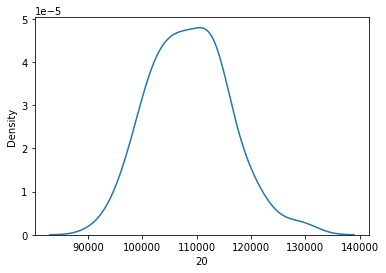

In [21]:
sns.kdeplot(trajectories_x[20])

In [22]:
trajectories_x

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,65830.565671,67323.606041,68561.194768,69790.156407,71406.502762,73147.601802,75016.801661,77018.779471,79147.744201,81154.700755,...,127784.701236,130333.443109,133052.869809,135929.838057,138671.858188,141056.732001,143414.214699,146088.930132,148983.483056,152011.150614
1,66047.024718,68221.545726,70638.651383,73237.883735,75711.573996,78007.369274,80015.507563,81831.482203,83477.917817,84971.549530,...,135282.510060,137095.247738,138942.232487,140840.617114,142786.794640,144671.048469,146374.031884,147946.983994,149568.899858,151211.767928
2,65953.942864,67815.771456,69545.960550,71096.768980,72626.205939,74095.476216,75546.002899,77149.067923,78877.270983,80598.328215,...,127159.527187,130324.679943,133607.049797,137020.239076,140672.868195,144531.837823,148568.147805,152604.445006,156695.241285,160870.486567
3,65935.950283,67793.671497,69744.249647,71722.562266,73603.125384,75211.932397,76510.002346,77598.104278,78625.619253,79755.160518,...,127308.816578,130822.182030,134354.907782,138082.374764,141929.638913,145689.342120,149242.923852,152516.213327,155780.520263,159038.646170
4,65851.296409,67493.198072,69277.259592,70989.940556,72898.219826,75133.023296,77293.994696,79263.390462,81220.702665,83577.414953,...,133213.709374,135821.679469,138268.447404,140597.442686,143034.585557,145444.463693,147752.904369,150151.510059,152677.821064,155066.964038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,66082.691955,68325.430742,70726.861767,73366.070699,76083.852865,78649.447168,80873.497357,82854.831999,84782.640507,87057.627803,...,133322.407561,135132.666550,137027.517258,138999.156350,140948.880209,142836.607533,144643.795843,146181.893935,147588.110701,149109.508520
97,66151.284854,68604.977749,71088.751344,73373.147973,75584.855552,77826.066578,79675.545461,81510.131948,83506.324376,85503.504988,...,134626.697950,137201.190663,139893.414571,142835.127842,145593.606230,148406.182732,151367.061081,154513.724257,157582.879347,160478.885528
98,65985.517562,67940.825141,69804.699326,71544.595894,73259.483768,75009.454121,76790.469495,78600.061560,80433.869088,82240.608110,...,134438.105073,137375.204982,140168.814762,142702.963299,145190.746857,147739.432888,150256.699577,152365.885459,154317.964090,156192.585728
99,66081.422086,68241.754342,70022.672506,71757.314478,73723.032874,75901.394858,78377.259537,80993.047942,83629.625380,86176.594227,...,135557.113194,137674.374147,139732.694146,141732.073189,143679.764797,145585.463972,147458.526680,149234.427438,150859.125525,152272.418145


In [23]:
delta_taus = []

for part in final_nodes:
        while part != None:
            tau = part.get_tau()
            parent = part.get_parent()
            if parent != None:
                tau_parent = parent.get_tau()
                delta_taus.append(int(tau - tau_parent))
            part = parent

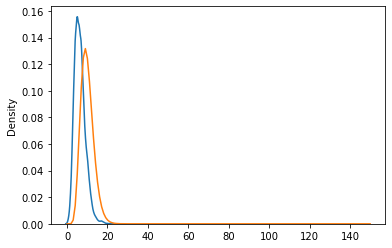

In [34]:
import scipy.stats as stats
sns.kdeplot(np.array(delta_taus)[np.array(delta_taus) >0]  )
x = np.linspace (0, 150, 150) 


#calculate pdf of Gamma distribution for each x-value
y = stats.gamma.pdf(x, a=10, scale=1)

#create plot of Gamma distribution
plt.plot(x, y)

#display plot
plt.show()

In [36]:
dist = np.array(delta_taus)[np.array(delta_taus) >0]  
from numpy import savetxt
savetxt('gibbs_ptpf.csv', dist, delimiter=',')